In [1]:
import networkx as nx
import numpy as np
from scipy import random
import copy
import random
from collections import OrderedDict
import pickle
import itertools
from multiprocessing import Pool
from utils_RSC_interactive_ABseparated import *
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#SC parameters
N = 600
k1 = 20
k2 = 6

p1, p2 = get_p1_and_p2(k1,k2,N)

In [3]:
import random as rd

def markovChain(beta_A, beta_D_A, mu_A, beta_B, beta_D_B, mu_B, epsilon_A, epsilon_B, node_neighbors_dict, tri_neighbors_dict, NSteps, i0_A, i0_B, i0_AB):
    N = len(node_neighbors_dict)
    
    #initial seeds
    p_A = np.zeros(N)
    p_A[rd.sample(range(N),int(N*i0_A))] = 1
    p_A_new = np.copy(p_A)
    
    p_B = np.zeros(N)
    p_B[rd.sample(range(N),int(N*i0_B))] = 1
    p_B_new = np.copy(p_B)
    
    p_AB = np.zeros(N)
    p_AB[rd.sample(range(N),int(N*i0_AB))] = 1
    p_AB_new = np.copy(p_AB)
    
    q_BA = 1
    q_AB = 1
    q_S = 1
    q_A = 1
    q_B = 1
    
    pATime = [np.mean(p_A)]
    pBTime = [np.mean(p_B)]
    pABTime = [np.mean(p_AB)]
    
    for k in range(0,NSteps):
        for i in range(0,N):
            #updating the infections - simple contagion
            for j in node_neighbors_dict[i]:
                q_BA *= 1-epsilon_B*beta_A*(p_A[j]+p_AB[j])
                q_AB *= 1-epsilon_A*beta_B*(p_B[j]+p_AB[j])
                q_S *= 1-beta_A*(p_A[j]+p_AB[j])-beta_B*(p_B[j]+p_AB[j])+beta_A*beta_B*p_AB[j]*p_AB[j]
                q_A *= 1-beta_A*(p_A[j]+p_AB[j])
                q_B *= 1-beta_B*(p_B[j]+p_AB[j])
                
            #updating the infections - triangle contagion
            for j, k in tri_neighbors_dict[i]:
                q_BA *= 1-epsilon_B*beta_D_A*(p_A[j]+p_AB[j])*(p_A[k]+p_AB[k])
                q_AB *= 1-epsilon_A*beta_D_B*(p_B[j]+p_AB[j])*(p_B[k]+p_AB[k])
                q_S *= 1-beta_D_A*(p_A[j]+p_AB[j])*(p_A[k]+p_AB[k])-beta_D_A*(p_B[j]+p_AB[j])*(p_B[k]+p_AB[k])+beta_D_A*beta_D_B*p_AB[j]*p_AB[j]*p_AB[k]*p_AB[k]
                q_A *= 1-beta_D_A*(p_A[j]+p_AB[j])*(p_A[k]+p_AB[k])
                q_B *= 1-beta_D_B*(p_B[j]+p_AB[j])*(p_B[k]+p_AB[k])
            
            #calculating f_A and f_B
            if ((1-q_A)*(1-0.5*(1-q_B))) == 0.0:
                f_A = 0.
            else:
                f_A=(1-q_A)*(1-0.5*(1-q_B))/((1-q_A)*(1-0.5*(1-q_B))+(1-q_B)*(1-0.5*(1-q_A)))
            if ((1-q_B)*(1-0.5*(1-q_A))) == 0.0:
                f_B = 0.
            else:            
                f_B=(1-q_B)*(1-0.5*(1-q_A))/((1-q_A)*(1-0.5*(1-q_B))+(1-q_B)*(1-0.5*(1-q_A)))
            
            #Updating the vectors
            p_AB_new[i] = p_B[i]*(1-mu_B)*(1-q_BA)+p_A[i]*(1-mu_A)*(1-q_AB)+p_AB[i]*(1-mu_A)*(1-mu_B)
            p_A_new[i] = p_B[i]*mu_B*(1-q_BA)+p_A[i]*(1-mu_A)*q_AB+p_AB[i]*mu_B*(1-mu_A)+(1-p_A[i]-p_B[i]-p_AB[i])*f_A*(1-q_S)
            p_B_new[i] = p_A[i]*mu_B*(1-q_AB)+p_B[i]*(1-mu_B)*q_BA+p_AB[i]*mu_A*(1-mu_B)+(1-p_A[i]-p_B[i]-p_AB[i])*f_B*(1-q_S)
            
            #resetting the parameters
            q_BA = 1
            q_AB = 1
            q_S = 1
            q_A = 1
            q_B = 1
        
        p_A = np.copy(p_A_new)
        p_B = np.copy(p_B_new)
        p_AB = np.copy(p_AB_new)
        
        pATime.append(np.mean(p_A))
        pBTime.append(np.mean(p_B))
        pABTime.append(np.mean(p_AB))
    
    return pATime, pBTime, pABTime

In [4]:
from collections import defaultdict

def get_tri_neighbors_dict(triangles_list):
    tri_neighbors_dict = defaultdict(list)
    for i, j, k in triangles_list:
        tri_neighbors_dict[i].append((j,k))
        tri_neighbors_dict[j].append((i,k))
        tri_neighbors_dict[k].append((i,j))
    return tri_neighbors_dict

In [5]:
node_neighbors_dict, triangles_list = generate_my_simplicial_complex_d2(N,p1,p2)
real_k = 1.*sum([len(v) for v in node_neighbors_dict.values()])/len(node_neighbors_dict)
real_kD = 3.*len(triangles_list)/len(node_neighbors_dict)

tri_neighbors_dict = get_tri_neighbors_dict(triangles_list)

mu_A = 0.05 #rec. prob. A
mu_B = 0.05 #rec. prob. A

lambda1s_A=[]
for i in np.arange(0, 2, 0.05):
    lambda1s_A.append(i)
lambdaD_A_target_list = [0,0.8,2.5]

lambda1_B = 1.5 #rescaled 1-simplex inf. prob. B
lambdaD_B = 0. #desired rescaled 2-simplex inf. prob. B

i0_A_list = [0.05,0.4] #initial conditions (% of infectious nodes at t=0) A
i0_B = 0.1 #initial conditions (% of infectious nodes at t=0) B
i0_AB = 0.0 #initial conditions (% of infectious nodes at t=0) AB

epsilon_A = 1.5
epsilon_B = 1.5

NSteps = 2000

1216 triangles created. Size now is 6069


In [6]:
def get_stationary_densities(pt_A, pt_B, pt_AB, last_k_values):
    rhos_A = np.mean(pt_A[-last_k_values:])
    rhos_B = np.mean(pt_B[-last_k_values:])
    rhos_AB = np.mean(pt_AB[-last_k_values:])
    
    return rhos_A, rhos_B, rhos_AB      

ValueError: x and y must have same first dimension, but have shapes (40,) and (80,)

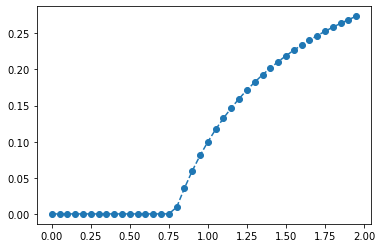

In [8]:
for i0_A in i0_A_list:
    for lambdaD_A_target in lambdaD_A_target_list:
        record_A = []
        record_B = []
        record_AB = []
        for lambda1_A  in lambda1s_A:
            beta_A = 1.*(mu_A/real_k)*lambda1_A #1-simplex inf. prob. A
            beta_D_A = 1.*(mu_A/real_kD)*lambdaD_A_target #2-simplex inf. prob. A

            beta_B = 1.*(mu_B/real_k)*lambda1_B #1-simplex inf. prob. B
            beta_D_B = 1.*(mu_B/real_kD)*lambdaD_B #2-simplex inf. prob. B
        
            pt_A, pt_B, pt_AB = markovChain(beta_A, beta_D_A, mu_A, beta_B, beta_D_B, mu_B, epsilon_A, epsilon_B, node_neighbors_dict, tri_neighbors_dict, NSteps, i0_A, i0_B, i0_AB)
        
            rhos_A, rhos_B, rhos_AB = get_stationary_densities(pt_A, pt_B, pt_AB, last_k_values=100)
        
            record_A.append(rhos_A)
            record_B.append(rhos_B)
            record_AB.append(rhos_AB)
        if lambdaD_A_target == 2.5:
            color = 'tab:green'
        if lambdaD_A_target == 0.8:
            color = 'tab:orange'
        if lambdaD_A_target == 0.:
            color = 'tab:blue'
        if i0_A == 0.05:
            label = 'lD='+str(lambdaD_A_target)
            plt.plot(lambda1s_A, record_A, 'o--', color=color, label=label)
        else:
            plt.plot(lambda1s_A, record_A, 'o--', color=color)
plt.xlabel('lambda1_A')
plt.ylabel('stationary density - state A')
plt.legend()
plt.show()        